In [2]:
# Попытка объединения решения XGB и NET на основе сравнения работы по train

In [3]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [36]:
import cv2 as cv

In [4]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, getProbX01, getTh, estimateResult

In [5]:
dirJ    = '../Work/Join-XGB-NET'
dirXGB1 = 'XGB-jpg256-tif256-LB=0x87170'
dirNET1 = 'VGG19-LB=0x90004'
Dirs = [os.path.join(dirJ,dirXGB1),os.path.join(dirJ,dirNET1)]

In [ ]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()

In [109]:
# Построение решения 0-1 исходя из пределов прохождения cc (построение через getTh)
def onlyCloudy (t01i, cloudy=9) :
    t01 = t01i.copy();
    if cloudy is not None :
        for i in range(t01.shape[0]) : 
                if t01[i,cloudy]==1 : t01[i,:]=0; t01[i,cloudy]=1;
    return(t01)

def getProbX01 (tPr, cc, weather=[0,3,9,10], cloudy=9) :
    t01  = np.zeros(tPr.shape,dtype=np.uint8);
    temp0 = tPr[:,weather].argmax(axis=1); #print(temp0[0:10])
    temp1 = np.array(weather)[temp0]
    for i in range(t01.shape[0]) : 
        temp2 = tPr[i,:]>cc
        t01[i,temp2]    = 1
        t01[i,weather]  = 0
        t01[i,temp1[i]] = 1
    t01 = onlyCloudy(t01,cloudy=cloudy)
    #print(temp1[0:10])
    #print(t01[0:10,weather+[1,2]])
    return(t01)

In [9]:
res = []
IY  = np.load(os.path.join(Dirs[0],'trIY-YY.npy'))
for iDir in Dirs :
    IPX   = np.load(os.path.join(iDir,'trIP-XX.npy')) # train result probability
    th,_  = getTh (IY,IPX)                            # throughs 
    IP01  = getProbX01(IPX,th)                        # train result 01
    res1  = estimateResult(IY,IP01)                   # estimating results on feature
    res.append((iDir,IPX,th,IP01,res1))     

In [14]:
xx = np.array([ii for _,_,_,_,ii in res]); xx.shape

(2, 17, 9)

In [32]:
xx[:,9:11,8]

array([[  11.,    6.],
       [ 386.,  712.]])

In [172]:
xx[:,0:9,8].astype(np.uint16)

array([[ 349,  367,  110,  347, 2574,  925, 2365, 2069,   61],
       [1181,  949, 3335, 1442, 2512, 1859, 2319, 2914,  208]], dtype=uint16)

In [162]:
np.array(labels)

array(['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation',
       'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy',
       'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
       'selective_logging', 'blow_down'], 
      dtype='|S17')

In [85]:
labels_df = pd.read_csv(trLabels)

# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list: label_list.append(label)
            
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
#rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
labels = label_list

In [164]:
resO = []
for iDir, _, th, _, _ in res :
    OPX   = np.load(os.path.join(iDir,'trOP-OX.npy')) # test result probability
    OPY   = np.load(os.path.join(iDir,'trOY-OY.npy')) # test result probability
    OP01  = getProbX01(OPX,th,cloudy=None)            # train result 01
    OP01  = pd.DataFrame(OP01,index=OPY)
    resO.append((iDir,OPX,th,OP01))

In [181]:
YP=resO[1][3]; SP=resO[0][3]

# 2017-07-12 Замена в NET значений отдельных признаков на признаки из XGB
# 2017-07-12 Эффект отрицательный
##for i in [9,10] : # LB = 0.89210 понижение
##for i in [11,12,13,14,15,16] : # LB = 0.89975 понижение
##for i in [0,1,2,3] : # LB = 0.88970 
for i in [4,6] : # LB = 0.87925
    YP[:][i] = SP[:][i]
#YP[:][9]  = SP[:][9]
#YP[:][10] = SP[:][10]

OXnew = YP.values
OYnew = YP.index.values

SP.values,YP.values
SP.values[YP[:][9]==1,:]

OXnew = onlyCloudy(OXnew)

OXnew,OYnew, len(OYnew)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ..., 
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]], dtype=uint8),
 array(['test_10002', 'test_10003', 'test_10004', ..., 'file_9997',
        'file_9998', 'file_9999'], dtype=object),
 61191)

In [182]:
# Строим результат

In [183]:
trZ = OXnew

In [184]:
temp_list = []
for i in range(trZ.shape[0]) :
    temp = [labels[ii] for ii in range(trZ.shape[1]) if trZ[i,ii]==1];
    temp = ' '.join(temp)
    temp_list.append([OYnew[i],temp])
temp_list.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))

In [185]:
temp_list[0:5],temp_list[-5:]

([['test_0', 'primary clear'],
  ['test_1', 'primary clear'],
  ['test_2', 'primary partly_cloudy'],
  ['test_3', 'primary clear'],
  ['test_4', 'cloudy']],
 [['file_20517', 'primary clear'],
  ['file_20518', 'primary partly_cloudy'],
  ['file_20519', 'primary agriculture clear'],
  ['file_20520', 'primary agriculture clear road'],
  ['file_20521', 'primary clear']])

In [186]:
rrr=pd.DataFrame(temp_list,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-12-23-34-16


In [187]:
rrr.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,cloudy


In [157]:
(0.90004-0.89210)/0.90004*100.0

0.8821830140882568

In [ ]:
#------------ Look&Analyze results

In [100]:
def pp (ll, tags=None, dir='../Data/jpg-v2-train', ext='.jpg', cols=4) :
    rows = (len(ll)-1)/cols+1
    plt.figure(figsize=(cols*5, rows*5));
    ii   = 0
    for ill in ll :
        image = cv.imread(os.path.join(dir,ill+ext),-1)
        plt.subplot(rows,cols,ii+1); plt.imshow(image);
        if (tags is not None) : plt.title(tags[ii]);
        ii+=1; 
    plt.show()
    plt.close()

In [105]:
ff = 9
cc = res[0][3][:,ff]<>res[1][3][:,ff]; cc
cc = res[0][3][:,ff]<>IY[:,ff]; cc

ll = labels_df[cc]['image_name'].tolist(); len(ll)
#labels_df[cc]['tags'].tolist()

11

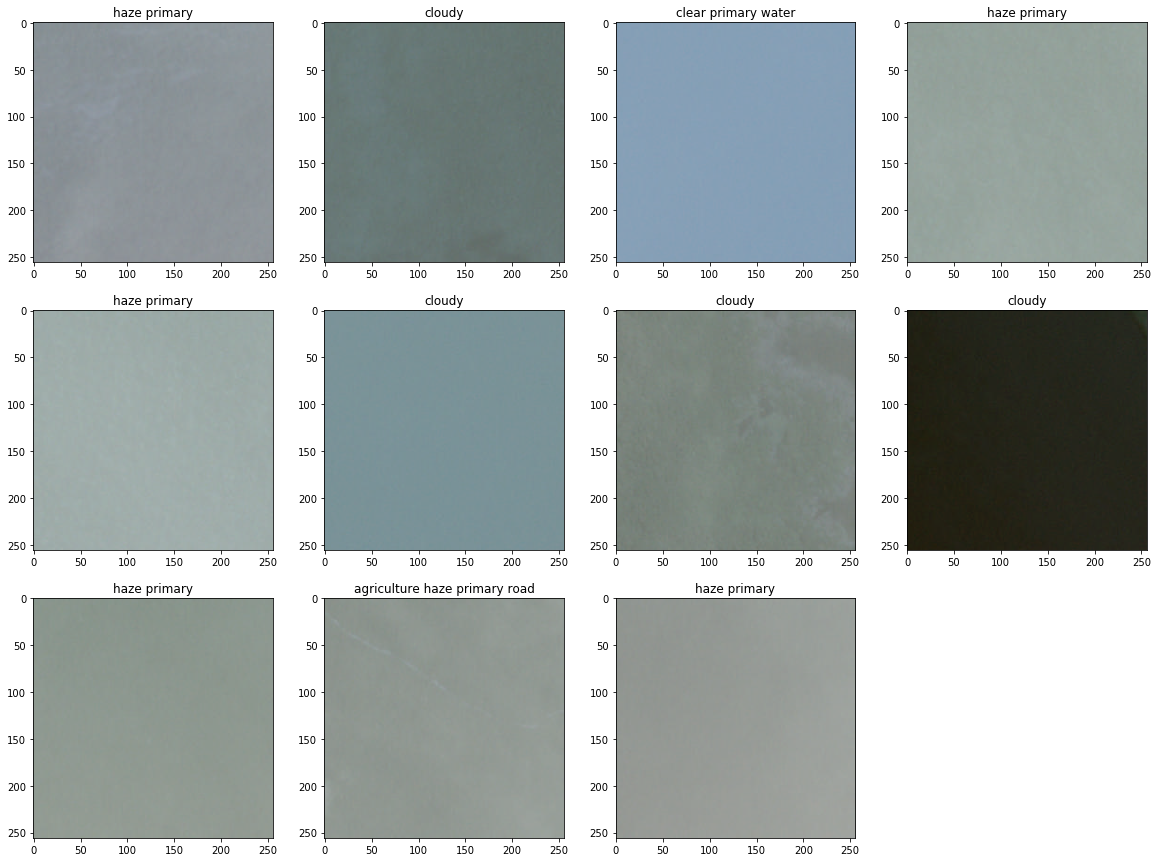

In [106]:
pp(ll, dir=trDirJPG, tags=labels_df[cc]['tags'].tolist())